# Simulation of a **pin** silicon solar cell

The following code loads the needed modules.

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from synumses.one_dimension.scharfetter_gummel_bernoulli import bernoulli, jacobian, update_b, first_jacobian, first_update_b, hole_current_density, electron_current_density

import synumses.one_dimension.parameters as parameters

from synumses.one_dimension.functions import calc_p_density, calc_n_density, calc_recombination

import synumses.one_dimension.solver as solver

## Definition of the solar cell
The silicon has a thickness of $l_\mathrm{x}=1\,\mathrm{\mu m}$ and the first and last  $50\,\mathrm{nm}$ are p and n doped, respectively.'<br>
There is no recombination.

In [2]:
parameters.n = 1000
parameters.lx = 1000E-9

parameters.init_geometry()

parameters.init_parameters()

#parameters.Cau = 0*1E-24

Na = 1.0E24
Nd = 1.0E24

Chi = 4.05
Eg = 1.12


# pn transistion at x1
x1 =  50E-9
x2 = 950E-9

for i in range(0, parameters.n):
    
    parameters.Chi[i] = Chi
    parameters.Eg[i] = Eg
    parameters.C[i]  = 0.0
    
    if parameters.pos_x[i] < x1:      
        parameters.C[i]  = -Na
        
    if parameters.pos_x[i] > x2:       
        parameters.C[i]  = Nd

## Plot diagram and doping levels

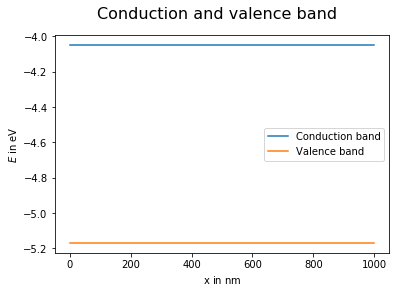

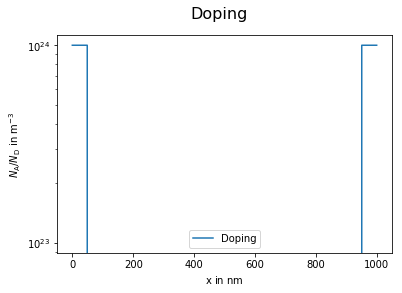

In [3]:
#
# Band diagram
#
fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Conduction and valence band", fontsize=16)

axis.plot(parameters.pos_x * 1E9, -parameters.Chi, label='Conduction band')
axis.plot(parameters.pos_x * 1E9, -parameters.Chi-parameters.Eg, label='Valence band')

axis.set_xlabel(r"x in $\mathrm{nm}$")
axis.set_ylabel(r"$E$ in $\mathrm{eV}$")

axis.legend()
plt.show()

#
# Doping level
#
fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Doping", fontsize=16)

axis.semilogy(parameters.pos_x * 1E9, np.abs(parameters.C), label='Doping')

axis.set_xlabel(r"x in $\mathrm{nm}$")
axis.set_ylabel(r"$N_\mathrm{A} / N_\mathrm{D}$ in $\mathrm{m^{-3}}$")

axis.legend()
plt.show()


## Solving without biasing
Now, let's apply a voltage of $0\,\mathrm{mV}$!.

In [4]:
solver.solve_from_doping()

solver.solve_no_bias()
bias_point = 0.0

solver.solve_bias(bias_point,0)

/home/pabele/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:133: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


Norm of b:  0.16541034860367182
Norm of x: 1.8147259294750683e-12


True

## Plot the band diagram

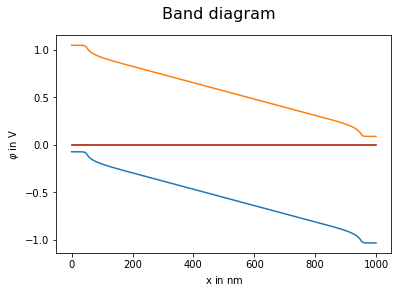

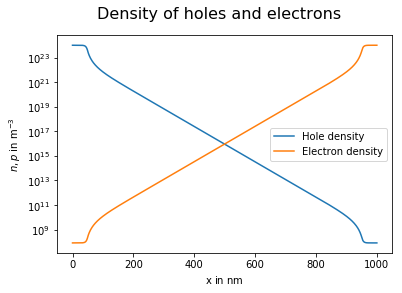

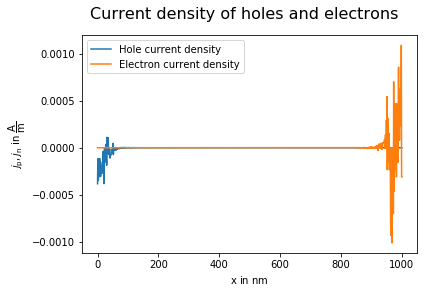

In [5]:
#
# Plot band diagram
#
fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Band diagram", fontsize=16)

axis.plot(parameters.pos_x * 1E9, -parameters.u[0::3] - parameters.Chi -  parameters.Eg, label='Valence band')
axis.plot(parameters.pos_x * 1E9, -parameters.u[0::3] - parameters.Chi                 , label='Conduction band')
axis.plot(parameters.pos_x * 1E9, -parameters.u[1::3]                                  , label='Quasi-Fermi-level of holes')
axis.plot(parameters.pos_x * 1E9, -parameters.u[2::3]                                  , label='Quasi-Fermi-level of electrons')

axis.set_xlabel(r"x in $\mathrm{nm}$")
axis.set_ylabel(r"$\varphi$ in $\mathrm{V}$")

plt.show()

#
# Electron and hole density
#
calc_p_density()
calc_n_density()
p = calc_p_density()
n = calc_n_density()

fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Density of holes and electrons", fontsize=16)

axis.semilogy(parameters.pos_x * 1E9, p, label='Hole density')
axis.semilogy(parameters.pos_x * 1E9, n, label='Electron density')

axis.set_xlabel(r"x in $\mathrm{nm}$")
axis.set_ylabel(r"$n,p$ in $\mathrm{m^{-3}}$")

axis.legend()
plt.show()


# Electron and hole current density 
j_p =     hole_current_density()
j_n = electron_current_density()

fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Current density of holes and electrons", fontsize=16)

axis.plot(parameters.pos_x * 1E9, j_p, label='Hole current density')
axis.plot(parameters.pos_x * 1E9, j_n, label='Electron current density')

axis.set_xlabel(r"x in $\mathrm{nm}$")
axis.set_ylabel(r"$j_\mathrm{p}, j_\mathrm{n}$ in $\mathrm{\dfrac{A}{m}}$")

axis.legend()
plt.show()

## Simulation with illumination
Now we illuminate the solar cell and simulate the short circuit current density.<br>
We assume a powerdensity of $1\,\mathrm{\dfrac{kW}{m^3}}$,
an absorption coefficient for silicon of $\alpha_\mathrm{Si} = 2.0\cdot 10^{6}\,\mathrm{m^{-1}}$, and
a light efficiency of $\eta = 0.6$. <br>
For the simulation to converge, the illumination must be ramped up, this takes some time.<br>


In [6]:
# For the simulatoin the illumination starts
# 10nm after and stops 10nm before the contacts.
x1 = 10E-9
x2 = 990E-9


bias_point = 0.0

eta = 0.6

I0 = 1E3

alpha = 2E6

dI0 = alpha*I0*eta

steps = 23

for i in range(steps):

    print("Step:", i,
          "Generation rate at the surface",
          dI0/(2**steps) * 2**(i+1) /(parameters.q * Eg))

    parameters.generation = np.where((parameters.pos_x  > x1) & (parameters.pos_x < x2),
                                     dI0/(2**steps) * 2**(i+1) * np.exp(-parameters.pos_x*alpha) /(parameters.q * Eg),
                                     0)

    solver.solve_bias(-bias_point,0)
    
    j = np.mean(hole_current_density() + electron_current_density())
    
    print("\t Current density:", j)
    

Step: 0 Generation rate at the surface 1.596552985055106e+21
Norm of b:  0.004447336968532245
Norm of x: 0.24729896525331982
Norm of b:  0.004741489472642524
Norm of x: 0.06645127428641803
Norm of b:  0.004551249709658963
Norm of x: 0.017540396985167045
Norm of b:  0.004717942464597084
Norm of x: 0.0012983809501576728
Norm of b:  0.004017596881470987
Norm of x: 7.709115729815603e-06
Norm of b:  0.004359895836516587
Norm of x: 3.1626237439773635e-10
	 Current density: -9.665664853659483e-05
Step: 1 Generation rate at the surface 3.193105970110212e+21
Norm of b:  0.003030418923443343
Norm of x: 0.12107608726267353
Norm of b:  0.004085602901193508
Norm of x: 0.02084883217276979
Norm of b:  0.004082839958468067
Norm of x: 0.001154984012869504
Norm of b:  0.004077689575441687
Norm of x: 4.310251690694416e-06
Norm of b:  0.004322975321238656
Norm of x: 7.250412422834348e-11
	 Current density: -0.00018270743246662875
Step: 2 Generation rate at the surface 6.386211940220424e+21
Norm of b:  0.0

## Plot the parameters with illumination
* generation rate,
* hole and electron density, and
* hole and electron current density.

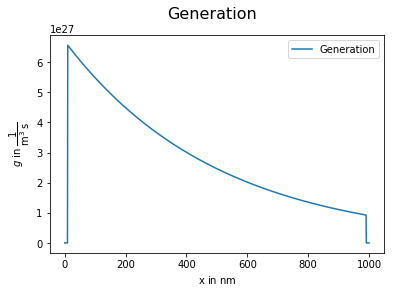

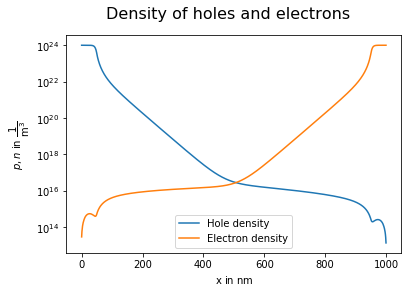

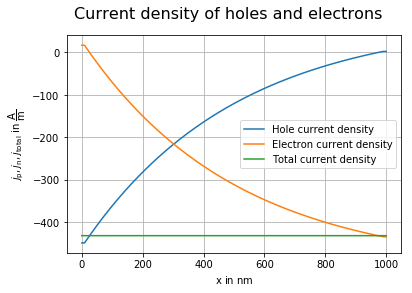

In [7]:
#
# Plot generation rate
#
fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Generation", fontsize=16)

axis.plot(parameters.pos_x * 1E9, parameters.generation, label='Generation')

axis.set_xlabel(r"x in $\mathrm{nm}$")
axis.set_ylabel(r"$g$ in $\mathrm{\dfrac{1}{m^3\, s}}$")

axis.legend()
plt.show()

#
# PLot hole and electron density
#
calc_p_density()
calc_n_density()

p = calc_p_density()
n = calc_n_density()

fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Density of holes and electrons", fontsize=16)

axis.semilogy(parameters.pos_x * 1E9, p, label='Hole density')
axis.semilogy(parameters.pos_x * 1E9, n, label='Electron density')

axis.set_xlabel(r"x in $\mathrm{nm}$")
axis.set_ylabel(r"$p, n$ in $\mathrm{\dfrac{1}{m^3}}$")

axis.legend()
plt.show()

#
# Plot hole and electron current density 
#
j_p =     hole_current_density()
j_n =     electron_current_density()

fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Current density of holes and electrons", fontsize=16)

axis.plot(parameters.pos_x * 1E9, j_p, label='Hole current density')
axis.plot(parameters.pos_x * 1E9, j_n, label='Electron current density')
axis.plot(parameters.pos_x * 1E9, j_n+j_p, label='Total current density')

axis.set_xlabel(r"x in $\mathrm{nm}$")
axis.set_ylabel(r"$j_\mathrm{p}, j_\mathrm{n}, j_\mathrm{total}$ in $\mathrm{\dfrac{A}{m}}$")

axis.legend()
axis.grid()
plt.show()

## Voltage sweep
Now, the voltage is swept to get the characteristics of the solar cell for illumination

In [8]:
u_start = 0.0
u_stop  = 0.50
u_step  = 0.025

voltage = []
current_density = []

bias_points = np.linspace(u_start, u_stop, int((u_stop-u_start)/u_step) + 2)
for bias_point in bias_points:

    solver.solve_bias(bias_point,0)   
    
    j = np.mean(hole_current_density() + electron_current_density())
    voltage.append(bias_point)
    current_density.append(j)
    print(bias_point, ",", j)
  

Norm of b:  0.0033714047965325107
Norm of x: 6.307758760483678e-14
0.0 , -431.6296835085217
Norm of b:  171428389153.3618
Norm of x: 0.8193746136031239
Norm of b:  45303.34472054477
Norm of x: 0.007463977392478595
Norm of b:  0.047555608618642
Norm of x: 6.740098618576345e-05
Norm of b:  0.004753257015522659
Norm of x: 1.2332228690061004e-08
0.023809523809523808 , -431.59818823388287
Norm of b:  171428389285.1708
Norm of x: 0.8209616620946
Norm of b:  74048.7125236649
Norm of x: 0.008177886929098748
Norm of b:  0.055307397238545636
Norm of x: 7.819895955940599e-05
Norm of b:  0.004638327560096609
Norm of x: 1.3488585162627645e-08
0.047619047619047616 , -431.56555387034103
Norm of b:  171428389412.98663
Norm of x: 0.8233212229168467
Norm of b:  45249.66493659721
Norm of x: 0.008907138432757502
Norm of b:  0.05586695761645336
Norm of x: 9.069825350641004e-05
Norm of b:  0.0035726301631850152
Norm of x: 1.5283407159275734e-08
0.07142857142857142 , -431.53194739385265
Norm of b:  171428389

## Plot solar cell characteristics
* the current density and 
* the power density.

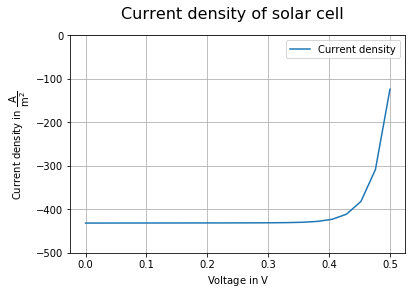

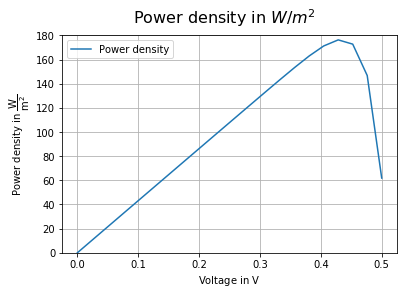

In [10]:
fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Current density of solar cell", fontsize=16)

axis.plot(voltage, current_density, label='Current density')

axis.set_xlabel(r"Voltage in $\mathrm{V}$")
axis.set_ylabel(r"Current density in $\mathrm{\dfrac{A}{m^2}}$")

axis.legend()
axis.grid()
plt.ylim(-500,0)
plt.show()


# Power density
fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Power density in $W/m^2$", fontsize=16)

axis.plot(voltage, -np.array(current_density)*np.array(voltage), label='Power density')

axis.set_xlabel(r"Voltage in $\mathrm{V}$")
axis.set_ylabel(r"Power density in $\mathrm{\dfrac{W}{m^2}}$")

axis.legend()
axis.grid()
plt.ylim(0,180)
plt.show()